In [1]:
# SCRIPT DOES BATCH COIN SEARCH OVER TREAINED MODEL
# 
# Configs:
# put some picture to TEST_DIR
# add your trained model: DATA_DIR, MODEL_FILE_PATH


import numpy as np
import os
from random import shuffle
import time
import csv
import ssl
from PIL import Image
import pandas as pd
import requests
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers, losses, activations, models, applications
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau #, TensorBoard
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

ssl._create_default_https_context = ssl._create_unverified_context

TEST_DIR = "/home/spa/coin-vision/data/_test1/"

DATA_DIR = "/home/spa/coin-vision/ssd-data/mini-400-20190205/"
DATASET_FILE_NAME = DATA_DIR + 'dataset.csv'
MODEL_LABELS_FILE_PATH = DATA_DIR + "labels.txt"
MODEL_FILE_PATH = DATA_DIR + "inception_v3_20190205-101836.hdf5"

ROWS=299
COLS=299

coinsDataset = pd.read_csv(DATASET_FILE_NAME)

print("TEST_DIR: " + TEST_DIR)
print(" ")
print("MODEL_FILE_PATH: " + MODEL_FILE_PATH)
print("MODEL_LABELS_FILE_PATH: " + MODEL_LABELS_FILE_PATH)



Using TensorFlow backend.


TEST_DIR: /home/spa/coin-vision/data/_test1/
 
MODEL_FILE_PATH: /home/spa/coin-vision/ssd-data/mini-400-20190205/inception_v3_20190205-101836.hdf5
MODEL_LABELS_FILE_PATH: /home/spa/coin-vision/ssd-data/mini-400-20190205/labels.txt


In [2]:
# LOAD LABELS AND TEST IMAGES

# load labels from the file
with open(MODEL_LABELS_FILE_PATH, mode='r') as infile:
    reader = csv.reader(infile)
    labels = {rows[0]:int(float(rows[1])) for rows in reader}
    
labels = labels.items()    

# load test image file names
test_images_paths = []
for subdir, dirs, files in os.walk(TEST_DIR):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        test_images_paths.append(filepath)
        
shuffle(test_images_paths)        
test_images_paths = test_images_paths[0:400] # get subset of 400

print('Images in test set: {}'.format(len(test_images_paths)))
print('Labels amount: {}'.format(len(labels)))

# Load test images into matrix

num_images = len(test_images_paths)

images_for_predict = np.zeros((num_images, 299, 299, 3))

for i in range(num_images):
    img = image.load_img(test_images_paths[i], target_size=(299, 299))
    y = image.img_to_array(img)
    y = np.expand_dims(y, axis=0)
    images_for_predict[i,:,:,:] = y[:,:,:]

    

Images in test set: 9
Labels amount: 400


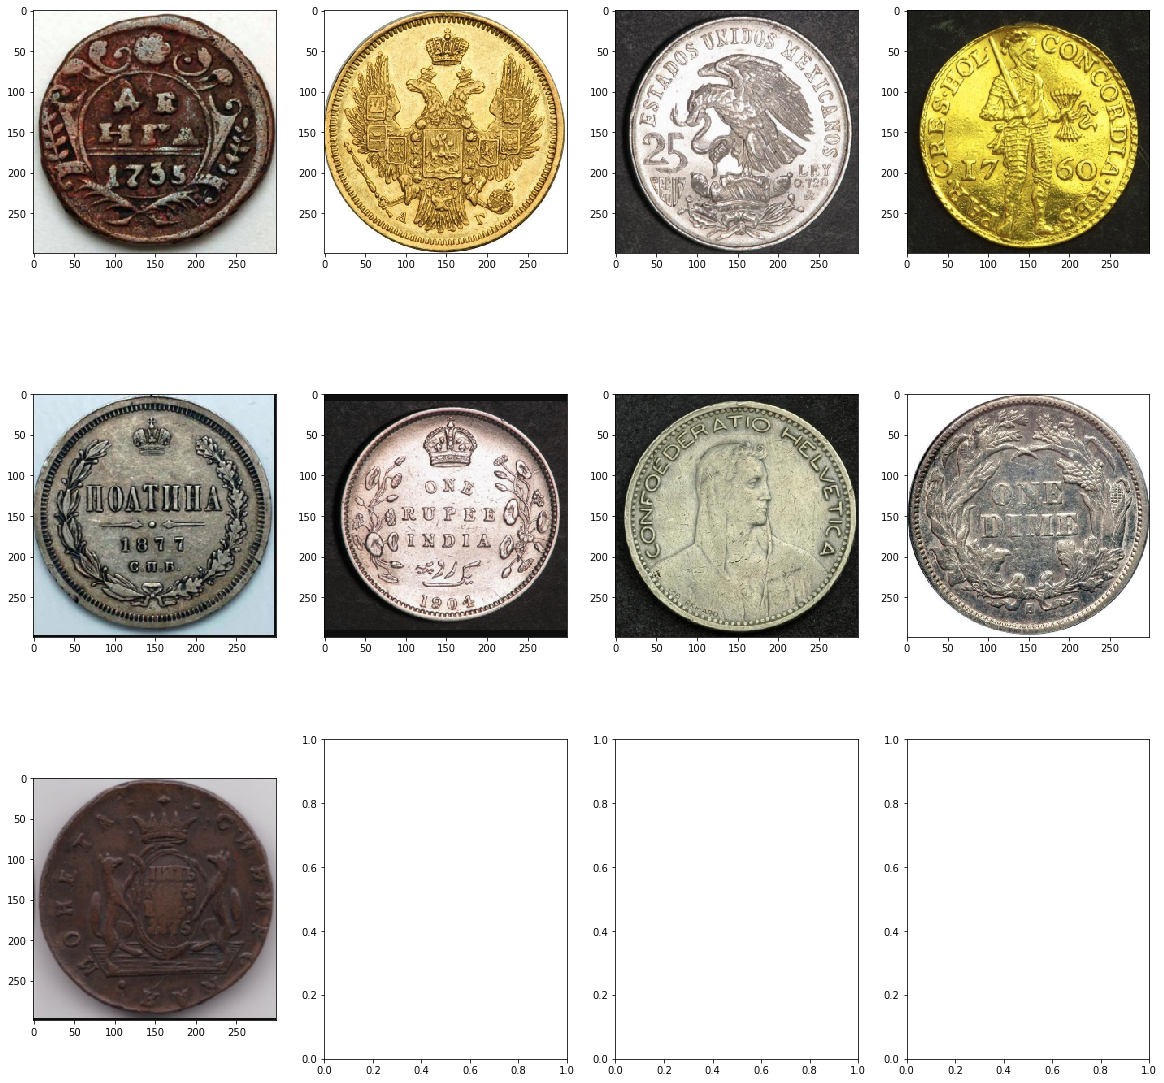

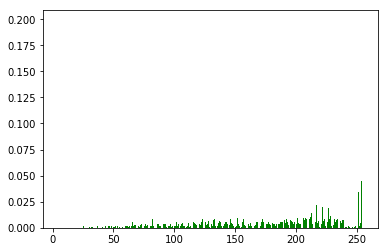

move from [0, 255] to [-1, 1] range


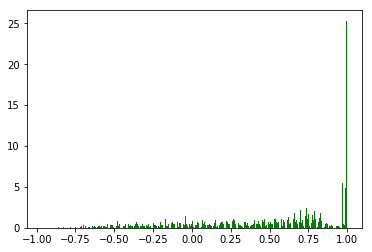

In [3]:
# Visualize test images and their histograms (to see what goes to NN input)

#convert type to int8 [0, 255] for visualization
img_to_plot_uint8 = images_for_predict.astype(np.uint8)

# plot first 12 images (if any)
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 3
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if i < num_images:
        plt.imshow(img_to_plot_uint8[i-1, :,:,:]) 
    
plt.show()

# plot histograms (to see what goes to NN input)
plt.hist(images_for_predict[0,:,:,1].reshape(ROWS, COLS), 50, density=1, facecolor='green')
plt.show()

# move from [0, 255] to [-1, 1] range
print('move from [0, 255] to [-1, 1] range')

images_for_predict = images_for_predict/127.5 - 1.0

plt.hist(images_for_predict[0,:,:,1].reshape(ROWS, COLS), 50, density=1, facecolor='green')
plt.show()


In [4]:
# DEFINE AND LOAD MODEL

input_shape = (ROWS, COLS, 3)
nclass = len(labels)

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
base_model.trainable = True

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dense(nclass, activation='softmax'))

model = add_model

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
model.summary()

# LOAD MODEL
model.load_weights(MODEL_FILE_PATH)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               819600    
Total params: 22,622,384
Trainable params: 22,587,952
Non-trainable params: 34,432
_________________________________________________________________


In [5]:
# DO PREDICTION

images_for_predict = images_for_predict[0:200,:,:,:] # get subset for single batch prediction (no loops over batches)

prediction = model.predict_classes(images_for_predict)
label_index = {v: k for k,v in labels}
predicts_label = [label_index[p] for p in prediction]
print(" prediction is done ")


 prediction is done 


original image  |  resized original image (input to NN)  |  predicted coin


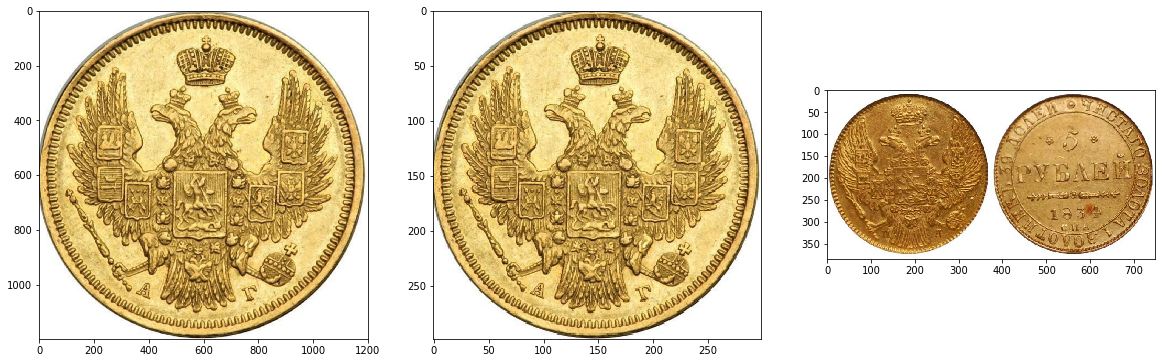

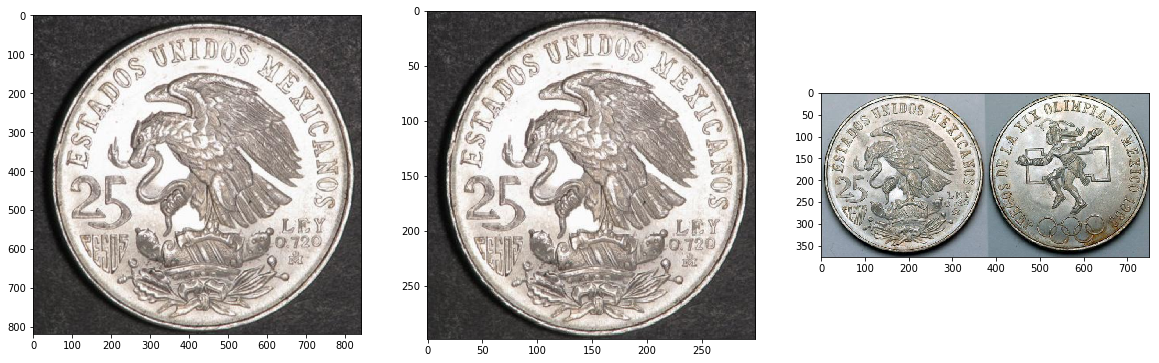

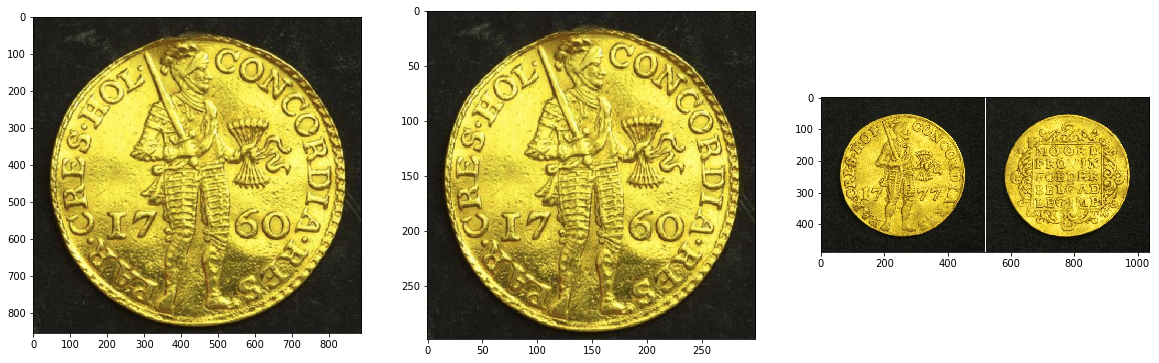

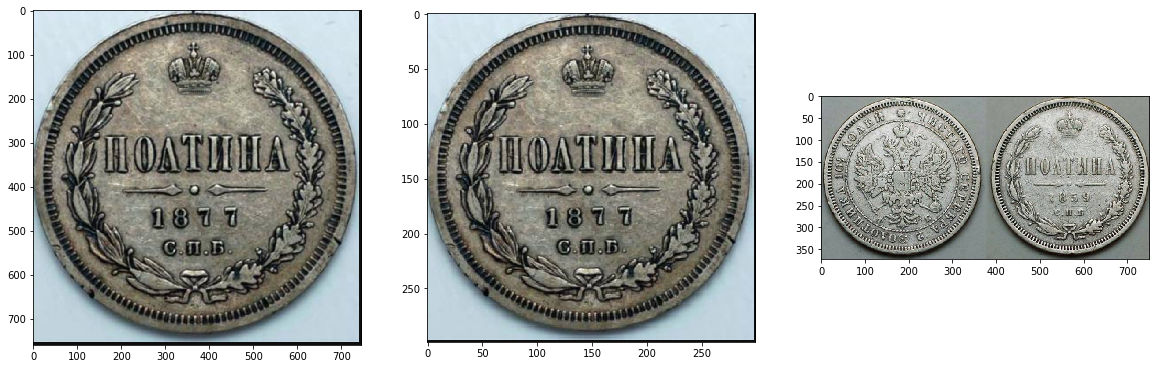

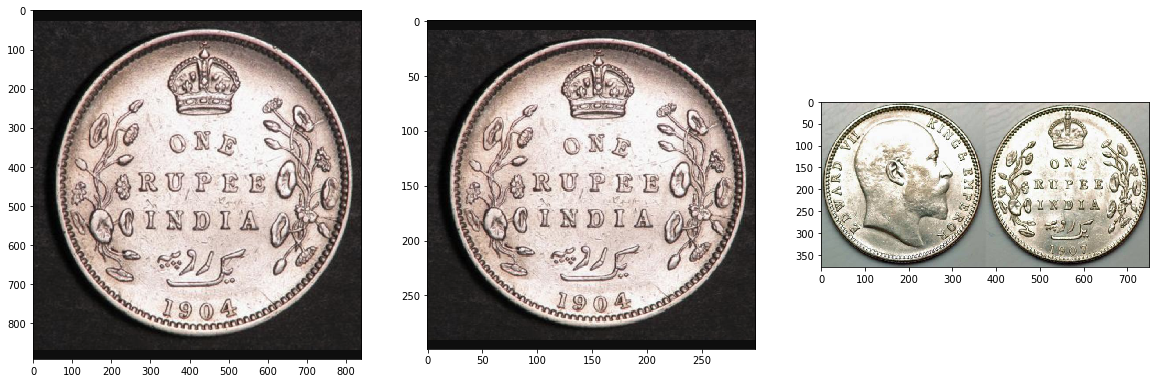

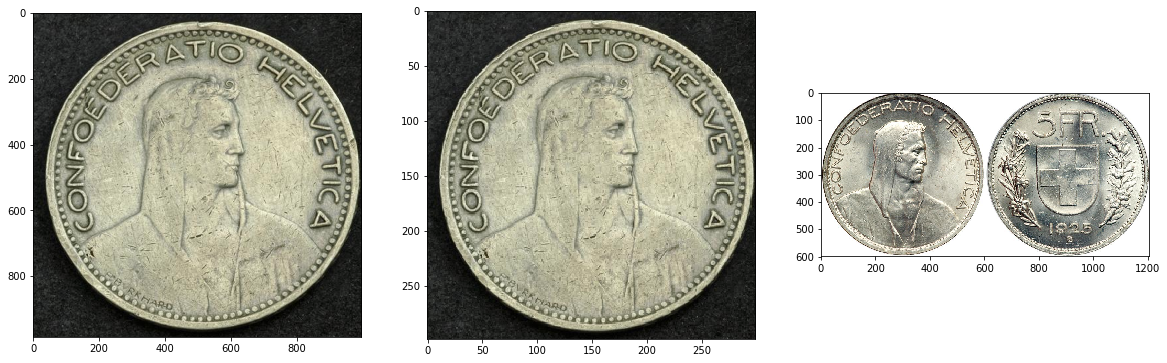

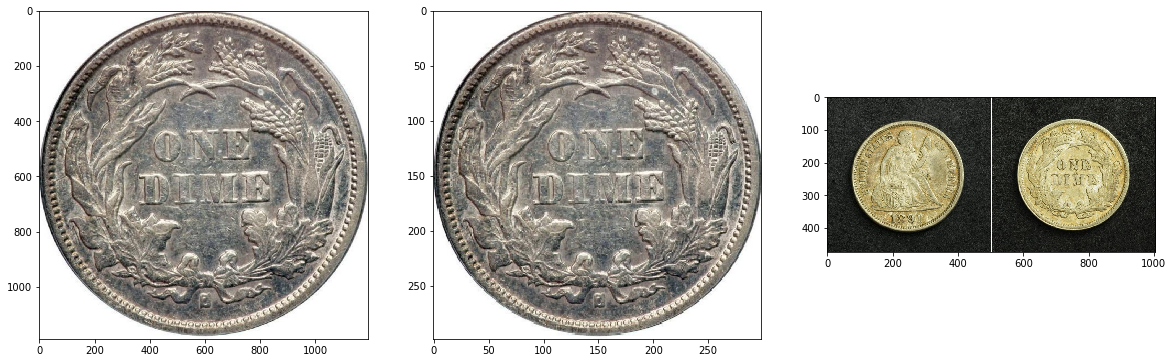

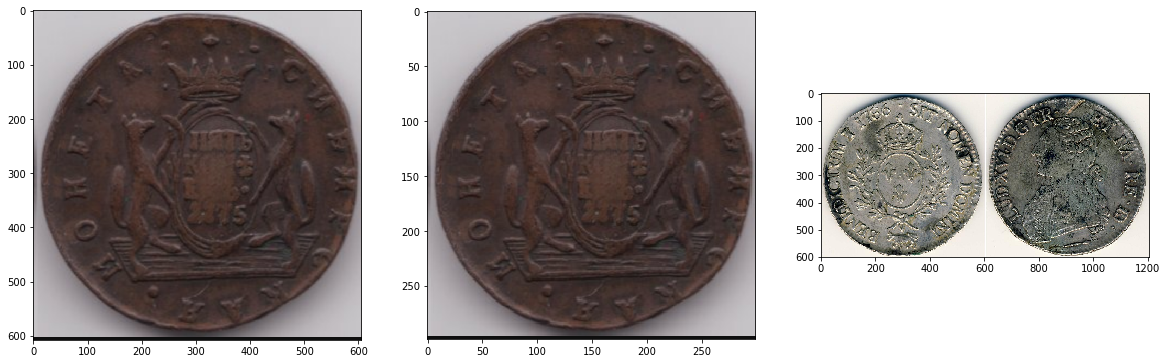

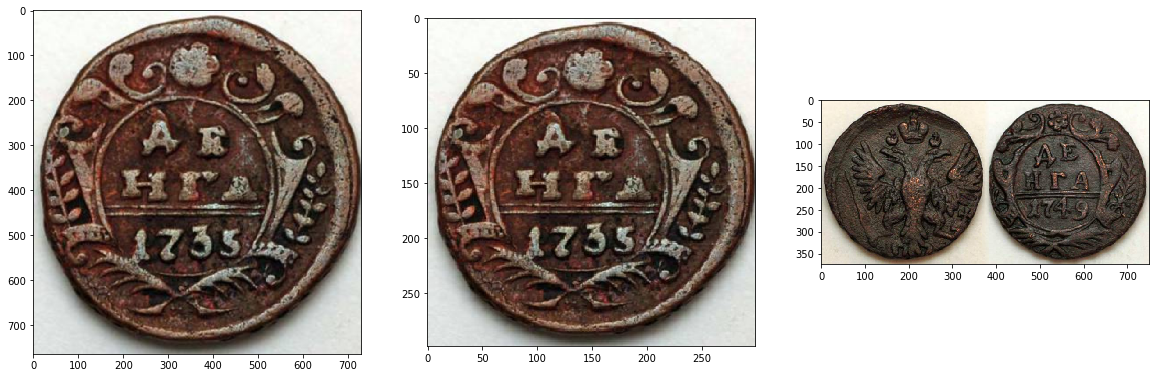

In [6]:
# Show: original image  |  resized original image (input to NN)  |  predicted coin

print('original image  |  resized original image (input to NN)  |  predicted coin')

# len(test_images_paths)
def getImageByCoinGroupId(coinsDataset, coinGroupId):
    coinGroupColumn = coinsDataset.loc[coinsDataset['coinGroupId'] == coinGroupId]
    imageId = coinGroupColumn.get('imageId').values[0]
    response = requests.get('https://d3k6u6bv48g1ck.cloudfront.net/fs/'+ imageId +'.jpg')
    return Image.open(BytesIO(response.content))


for i in range(len(predicts_label)):
    # original image for prediction
    test_img = image.load_img(test_images_paths[i])
    # resized image for prediction
    img = image.load_img(test_images_paths[i], target_size=(299, 299))
    # predicted image
    predicted_img = getImageByCoinGroupId(coinsDataset, predicts_label[i])
    
    fig=plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 3, 1)
    plt.imshow(test_img)
    fig.add_subplot(1, 3, 2)
    plt.imshow(img)
    fig.add_subplot(1, 3, 3)
    plt.imshow(predicted_img)
    plt.show()
    
    